# Library Import

In [1]:
#-- Basics Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
from sklearn.preprocessing import MinMaxScaler


#-- Metrics Calculation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE


#-- Tensor Flow (NN and Deep Learning)
from tensorflow.keras import models, layers, losses, optimizers, activations, metrics, regularizers, callbacks, utils, initializers
import tensorflow as tf

#-- Warnings OFF
from warnings import simplefilter



simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['PYTHONHASHSEED']=str('123')


%matplotlib inline

# Function definition

In [2]:
def esc_bootstrap(main_df,deltaT,scaler,X,y,lag_list,pred_list,split_esc,sample=5):
  
  metrics_list = []

  for i in range(sample):

    model_temp = MLP(look_back=12,vec_num=1)

    model_temp.fit(X_train, y_train,
                epochs=250,
                batch_size=X_train.shape[0],
                verbose=0,
                validation_data = (X_test, y_test),
                shuffle=True,
                workers=10, use_multiprocessing=True)
    
    pred_df = main_df[lag_list].copy()
    pred_df[pred_list] = model_temp.predict(main_df[lag_list],verbose=False)
    pred_df = etuni_2_abs(pred_df, deltaT=deltaT)[pred_list]

    df_escalar = main_df[['date']].copy()
    df_escalar['real'] = scaler.inverse_transform(main_df[['pred_1']])
    df_escalar['pred'] = scaler.inverse_transform(pred_df)
    df_escalar['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_escalar.index]

    test = df_escalar[df_escalar.tipo == 'Teste']
    train = df_escalar[df_escalar.tipo == 'Treino']


    metric_df_final = pd.DataFrame(
        {
        'sample': [i,i],
        'tipo':['Treino','Teste'],
        'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
        'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
        'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
        'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
        }
    )

    metrics_list.append(metric_df_final.copy())
    teste = pd.concat(metrics_list)
    teste.to_csv('teste.csv',index=False)
    print(i)

  return metrics_list

In [3]:
def df_transform(path, name):
  '''
    O conjunto de dados em relação aos rios é composto por duas séries
    históricas, cada uma representa a vazão média em [m^3/ s] de um
    determinado mês das usinas hidroelétricas de Furnas e Camargos. Estas
    séries históricas apresentam alta correlação que pode ser explicada pelo
    fato de que ambas as usinas estão situadas no Rio Grande, na bacia do
    Rio Paraná. Os dados são de 82 anos do histórico de operação dessas duas
    usinas hidroelétricas, totalizando 984 amostras mensais desde janeiro de
    1931 até dezembro de 2012, adquiridos pela ONS (Operador Nacional do
    Sistema Elétrico).
  '''

  ## Sequence list of data
  #/content/drive/MyDrive/Colab Notebooks/Tese Mestrado/Rio 01 Camargos.txt
  #/content/drive/MyDrive/Colab Notebooks/Tese Mestrado/Rio 02 Furnas.txt

  df = pd.read_csv(path,sep='\t',header=None)
  df.columns = ['01','02','03',
                '04','05','06',
                '07','08','09',
                '10','11','12']
  df_melted = pd.melt(df)
  

  lista_aux = []
  for i in df_melted.variable.unique():
    for year in range(1931,2013):
      lista_aux.append(year)

  df_melted['year'] = lista_aux
  df_melted['date'] = pd.to_datetime(df_melted.variable.astype(str) + '/' + df_melted['year'].astype(str),format='%m/%Y')
  df_melted.sort_values('date',inplace=True)
  df_melted['name'] = name
  df_melted.reset_index(inplace=True,drop=True)
  
  return df_melted[['date','value','name']]


In [4]:
# Create NN model
def MLP(look_back,vec_num=1):
    
    entrada = layers.Input(shape=look_back)
    estimativa = layers.Dense(24, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(entrada)
    estimativa = layers.Dense(12, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(estimativa)
    estimativa = layers.Dense(12, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(estimativa)
    estimativa = layers.Dense(6, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(estimativa)
    estimativa = layers.Dense(vec_num, activation=activations.linear,kernel_initializer=initializers.LecunNormal())(estimativa)
  
    model = models.Model(inputs=[entrada], outputs=estimativa)

    model.compile(optimizer=optimizers.Adam(), loss='mse',
                  metrics=['mae','mse','mape'])
    return model

In [5]:
def escalar_etuni_build(df,deltaT=0.1):
  df_temp = df[['date','value_norm']].copy()
  df_temp.columns = ['date','lag_12']
  for i in range(1,look_back + 1):
    df_temp['lag_'+str(12-i)] = df_temp['lag_12'].shift(-i) 

  df_temp.rename({'lag_0':'pred_1'},inplace=True,axis=1)
  df_temp.dropna(how='any',inplace=True,axis=0)
  df_temp.reset_index(drop=True,inplace=True)

  df_temp['date'] = df['date'].tail(df_temp.shape[0]).to_list()

  df_aux = df_temp.copy()
  for i in range(len(df_temp.columns)):
    if i in (0,1):
      df_aux['mean_'+'lag_12'] = df_temp['lag_12']
      continue
    else:
      col_i = df_temp.columns[i-1]
      col_f = df_temp.columns[i]
      df_aux['mean_'+col_f] = (df_temp[col_f] - df_temp[col_i])/deltaT
           
  return df_aux 

In [6]:
def vetorial_etuni_build(df,deltaT = 0.1):
  df_temp = df[['date','value_norm']].copy()
  df_temp.columns = ['date','lag_12']
  aux = []
  split_list = [x for x in range(0,df_temp.shape[0] + 1,look_back)]
  for i in range(1,len(split_list)):
    final = split_list[i]
    inicio = split_list[i-1]
    aux.append(df_temp['lag_12'].iloc[inicio:final].to_list())
    
  aux_df = pd.DataFrame(aux) 
  aux_df.columns = ['lag_'+str(x) for x in range(12,0,-1)]

  for i in range(1,len(aux_df.columns)+1):
    aux_df['pred_'+str(i)] = aux_df['lag_'+str(13-i)].shift(-1)
                
  aux_df.dropna(how='any', axis=0,inplace=True)

  df_aux = aux_df.copy()
  for i in range(len(aux_df.columns)):
    if i == 0:
      df_aux['mean_'+'lag_12'] = aux_df['lag_12']
    else:
      col_i = aux_df.columns[i-1]
      col_f = aux_df.columns[i]
      df_aux['mean_'+col_f] = (aux_df[col_f] - aux_df[col_i])/deltaT

  return df_aux 

In [7]:
def etuni_2_abs(df, deltaT=0.1):
  mean_cols = [x for x in df.columns if 'mean' in x]

  df_temp = df.copy()
  for i in range(len(mean_cols)):
    if i == 0:
      continue
    else:
      col_i = mean_cols[i-1]
      col_f = mean_cols[i]
      df_temp[col_f] = df_temp[col_f]*deltaT + df_temp[col_i]

  return df_temp

In [8]:
# Plot and save loss function from model history
def model_loss(history,method_name):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title(f'model loss - {method_name}')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.savefig(f'model_loss_{method_name}.png', format='png')
    plt.show();

In [9]:
#-- Parameters
look_back = 12
num_month = 12
vec_num = 12
deltaT = 0.5

#-- Training and fitting
test_size = 12*10
epochs=1000
batch_size= 120

# Camargos

In [10]:
camargos_raw = df_transform('https://raw.githubusercontent.com/thiagolopes97/E-TUNI_NARMAX_RIVER/main/Datasets/Rio%2001%20Camargos.txt',
                        'Camargos')

camargos_scaler = MinMaxScaler()
camargos_raw['value_norm'] = camargos_scaler.fit_transform(camargos_raw[['value']])

In [11]:
esc_camargos = escalar_etuni_build(camargos_raw,deltaT=deltaT)
vec_camargos = vetorial_etuni_build(camargos_raw,deltaT=deltaT)

In [12]:
model_esc = MLP(look_back,vec_num=1)
model_vec = MLP(look_back,vec_num=12)


## Escalar 

In [33]:
lag_list = [x for x in esc_camargos.columns if 'mean_lag' in x]
pred_list = ['mean_pred_1']

In [34]:
X = esc_camargos[lag_list].copy()
y = esc_camargos[pred_list].copy()

split_esc = esc_camargos.shape[0] - 12*10
split_vec = vec_camargos.shape[0] - 10

X_train, X_test = X.iloc[:split_esc,:],X.iloc[split_esc:,:]
y_train, y_test = y.iloc[:split_esc,:],y.iloc[split_esc:,:]


In [35]:
filePath = "/content/esc_weights_etuni_camargos.hdf5"
model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=filePath,
      save_weights_only=True,
      monitor='val_mse',
      mode='min',
      save_best_only = True
      )



model_esc.fit(X_train, y_train,
              epochs=100,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_train, y_train),
              callbacks=[model_checkpoint_callback],
              shuffle=True,
              workers=10, use_multiprocessing=True)
  



Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:

model_loss(model_esc.history,method_name='NARMAX_ESCALAR')
#model_esc.load_weights(filePath)

In [ ]:
pred_df = esc_camargos[lag_list].copy()
pred_df[pred_list] = model_esc.predict(esc_camargos[lag_list])
pred_df = etuni_2_abs(pred_df, deltaT=deltaT)[pred_list]



In [ ]:

df_escalar = esc_camargos[['date']].copy()
df_escalar['real'] = camargos_scaler.inverse_transform(esc_camargos[['pred_1']])
df_escalar['pred'] = camargos_scaler.inverse_transform(pred_df)
df_escalar['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_escalar.index]
df_escalar.to_csv('camargos_pred_results_etuni.csv',index=False)

display(df_escalar.head())
display(df_escalar.tail())

In [ ]:

test = df_escalar[df_escalar.tipo == 'Teste']
train = df_escalar[df_escalar.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('camargos_metrics_esc_etuni.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - ETUNI R2: {r2_result:.2f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'Camargos Escalar results.png', format='png')

plt.show()

In [ ]:
aow = esc_bootstrap(esc_camargos,deltaT,camargos_scaler,X,y,lag_list,pred_list,split_esc,sample=100)

In [ ]:
teste = pd.concat(aow)
teste.to_csv('teste.csv',index=False)

In [ ]:

sns.histplot(data=teste,x='R2',hue='tipo',kde=True)

## Vetorial

In [ ]:

lag_list = [x for x in vec_camargos.columns if 'mean_lag' in x]
pred_list = [x for x in vec_camargos.columns if 'mean_pred' in x]

X = vec_camargos[lag_list].copy()
y = vec_camargos[pred_list].copy()

split_vec = vec_camargos.shape[0] - 10

X_train, X_test = X.iloc[:split_vec,:],X.iloc[split_vec:,:]
y_train, y_test = y.iloc[:split_vec,:],y.iloc[split_vec:,:]





filePath = "/content/vec_weights_etuni_camargos.hdf5"
model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=filePath,
      save_weights_only=True,
      monitor='val_mse',
      mode='min',
      save_best_only = True
      )



model_vec.fit(X_train, y_train,
              epochs=1000,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_test, y_test),
              callbacks=[model_checkpoint_callback],
              shuffle=True,
              workers=10, use_multiprocessing=True)
  


model_loss(model_vec.history,method_name='NARMAX_ESCALAR')
model_vec.load_weights(filePath)
pred_df = vec_camargos[lag_list].copy()
pred_df[pred_list] = model_vec.predict(vec_camargos[lag_list])
pred_df = etuni_2_abs(pred_df, deltaT=deltaT)[pred_list]



In [37]:
pred_df

,mean_pred_1,mean_pred_2,mean_pred_3,mean_pred_4,mean_pred_5,mean_pred_6,mean_pred_7,mean_pred_8,mean_pred_9,mean_pred_10,mean_pred_11,mean_pred_12
0,0.469366,0.353139,0.319314,0.137262,0.104039,0.068935,0.002203,-0.033430,-0.000462,0.024563,0.126549,0.328635
1,0.484955,0.450721,0.410696,0.293700,0.242245,0.225355,0.207649,0.197054,0.208406,0.227483,0.280168,0.403308
2,0.293927,0.272715,0.244682,0.122728,0.069594,0.038003,0.025421,0.013815,0.018308,0.033734,0.082276,0.183986
3,0.431871,0.410022,0.366347,0.262734,0.207469,0.194769,0.188704,0.185803,0.196443,0.214376,0.261303,0.370202
4,0.223928,0.153786,0.125933,-0.015405,-0.068667,-0.099819,-0.143054,-0.170646,-0.168394,-0.146724,-0.072626,0.080565
...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.202935,0.168161,0.141547,0.008699,-0.042453,-0.077273,-0.102665,-0.119441,-0.122780,-0.099132,-0.042979,0.070149
77,0.532752,0.449296,0.423579,0.274143,0.221870,0.188014,0.138440,0.105931,0.113855,0.132389,0.214182,0.381241
78,0.553303,0.500862,0.467106,0.335854,0.285690,0.262682,0.231463,0.210367,0.222979,0.239913,0.301915,0.444485
79,0.579070,0.545909,0.518362,0.387581,0.336484,0.303361,0.280107,0.263990,0.264017,0.285342,0.340138,0.453384


In [36]:
teste = pred_df.T.copy()
list_df = []
for col in teste.columns:
  list_df.append(teste[[col]])

pd.concat(list_df, ignore_index=True,verify_integrity=False,axis=1)             

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
mean_pred_1,0.469366,0.484955,0.293927,0.431871,0.223928,0.431760,0.738911,0.521209,0.449782,0.433484,...,0.357534,0.289329,0.397551,0.357564,0.360389,0.202935,0.532752,0.553303,0.579070,0.554138
mean_pred_2,0.353139,0.450721,0.272715,0.410022,0.153786,0.367370,0.698343,0.468499,0.386651,0.403782,...,0.328345,0.268995,0.336549,0.339537,0.322350,0.168161,0.449296,0.500862,0.545909,0.541151
mean_pred_3,0.319314,0.410696,0.244682,0.366347,0.125933,0.336635,0.660993,0.435253,0.358130,0.362259,...,0.286664,0.224811,0.302140,0.294507,0.283250,0.141547,0.423579,0.467106,0.518362,0.561147
mean_pred_4,0.137262,0.293700,0.122728,0.262734,-0.015405,0.190152,0.540361,0.305394,0.223550,0.249969,...,0.174921,0.122762,0.160137,0.194755,0.161912,0.008699,0.274143,0.335854,0.387581,0.406124
mean_pred_5,0.104039,0.242245,0.069594,0.207469,-0.068667,0.146273,0.486462,0.252971,0.165348,0.198152,...,0.122986,0.067427,0.115967,0.139770,0.112867,-0.042453,0.221870,0.285690,0.336484,0.345553
mean_pred_6,0.068935,0.225355,0.038003,0.194769,-0.099819,0.120266,0.464902,0.228498,0.132153,0.184014,...,0.109069,0.055708,0.092161,0.130084,0.096153,-0.077273,0.188014,0.262682,0.303361,0.259721
mean_pred_7,0.002203,0.207649,0.025421,0.188704,-0.143054,0.077067,0.441469,0.197109,0.091396,0.171353,...,0.096920,0.051368,0.054175,0.128720,0.075811,-0.102665,0.138440,0.231463,0.280107,0.244238
mean_pred_8,-0.033430,0.197054,0.013815,0.185803,-0.170646,0.047411,0.429321,0.177131,0.069835,0.162635,...,0.088485,0.049048,0.029756,0.126868,0.061725,-0.119441,0.105931,0.210367,0.263990,0.212020
mean_pred_9,-0.000462,0.208406,0.018308,0.196443,-0.168394,0.065546,0.429309,0.183377,0.052562,0.179388,...,0.105427,0.061776,0.049057,0.145283,0.080094,-0.122780,0.113855,0.222979,0.264017,0.201349
mean_pred_10,0.024563,0.227483,0.033734,0.214376,-0.146724,0.081795,0.454944,0.203629,0.086101,0.194241,...,0.120086,0.078108,0.066864,0.157490,0.094954,-0.099132,0.132389,0.239913,0.285342,0.195352


In [24]:

pred_df

,mean_pred_1,mean_pred_2,mean_pred_3,mean_pred_4,mean_pred_5,mean_pred_6,mean_pred_7,mean_pred_8,mean_pred_9,mean_pred_10,mean_pred_11,mean_pred_12
0,0.469366,0.353139,0.319314,0.137262,0.104039,0.068935,0.002203,-0.033430,-0.000462,0.024563,0.126549,0.328635
1,0.484955,0.450721,0.410696,0.293700,0.242245,0.225355,0.207649,0.197054,0.208406,0.227483,0.280168,0.403308
2,0.293927,0.272715,0.244682,0.122728,0.069594,0.038003,0.025421,0.013815,0.018308,0.033734,0.082276,0.183986
3,0.431871,0.410022,0.366347,0.262734,0.207469,0.194769,0.188704,0.185803,0.196443,0.214376,0.261303,0.370202
4,0.223928,0.153786,0.125933,-0.015405,-0.068667,-0.099819,-0.143054,-0.170646,-0.168394,-0.146724,-0.072626,0.080565
...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.202935,0.168161,0.141547,0.008699,-0.042453,-0.077273,-0.102665,-0.119441,-0.122780,-0.099132,-0.042979,0.070149
77,0.532752,0.449296,0.423579,0.274143,0.221870,0.188014,0.138440,0.105931,0.113855,0.132389,0.214182,0.381241
78,0.553303,0.500862,0.467106,0.335854,0.285690,0.262682,0.231463,0.210367,0.222979,0.239913,0.301915,0.444485
79,0.579070,0.545909,0.518362,0.387581,0.336484,0.303361,0.280107,0.263990,0.264017,0.285342,0.340138,0.453384


In [ ]:

df_escalar = vec_camargos[['date']].copy()
df_escalar['real'] = camargos_scaler.inverse_transform(esc_camargos[['pred_1']])
df_escalar['pred'] = camargos_scaler.inverse_transform(pred_df)
df_escalar['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_escalar.index]
df_escalar.to_csv('camargos_pred_results_etuni_vec.csv',index=False)

display(df_escalar.head())
display(df_escalar.tail())

test = df_escalar[df_escalar.tipo == 'Teste']
train = df_escalar[df_escalar.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('camargos_metrics_vec_etuni.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - ETUNI R2: {r2_result:.2f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'Camargos Vetorial E-TUNI results.png', format='png')

plt.show()

In [ ]:


X = vec_camargos[lag_list].copy()
y = vec_camargos[pred_list].copy()

X_train, X_test = X.iloc[:split_vec,:],X.iloc[split_vec:,:]
y_train, y_test = y.iloc[:split_vec,:],y.iloc[split_vec:,:]

In [ ]:


# filePath = "/content/camargos_vec_weights_narmax.hdf5"
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#       filepath=filePath,
#       save_weights_only=True,
#       monitor='val_mse',
#       mode='min',
#       save_best_only = True
#       )


model_vec.fit(X_train, y_train,
              epochs=2500,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_train, y_train),
#              callbacks=[model_checkpoint_callback],
              shuffle=True)


In [ ]:

#model_loss(model_vec.history,method_name='NARMAX_VETORIAL')
#model_vec.load_weights(filePath)

In [ ]:

df_vec = esc_camargos[['date']].copy()
df_vec['real'] = camargos_scaler.inverse_transform(vec_2_esc(y))
df_vec['pred'] = camargos_scaler.inverse_transform(vec_2_esc(pd.DataFrame(model_vec.predict(X))))
df_vec['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_vec.index]
#df_vec.to_csv('camargos_pred_results_vec.csv',index=False)


In [ ]:

test = df_vec[df_vec.tipo == 'Teste']
train = df_vec[df_vec.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
#metric_df_final.to_csv('camargos_metrics_vec.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

#plt.savefig(f'Camargos Vetorial results NARMAX.png', format='png')

plt.show()

In [ ]:
aow = vec_bootstrap(esc_camargos,camargos_scaler,X,y,lag_list,pred_list,split_esc,sample=100)


In [ ]:

teste = pd.concat(aow).reset_index(drop=True)
teste

In [ ]:

teste.to_csv('teste_camargos_vec_bootstrap.csv',index=False)

In [ ]:

sns.histplot(data=teste,x='R2',hue='tipo',kde=True)

# Furnas

In [10]:
furnas_raw = df_transform('https://raw.githubusercontent.com/thiagolopes97/E-TUNI_NARMAX_RIVER/main/Datasets/Rio%2002%20Furnas.txt',
                        'Furnas')

furnas_scaler = MinMaxScaler()
furnas_raw['value_norm'] = furnas_scaler.fit_transform(furnas_raw[['value']])

In [11]:
esc_furnas = escalar_etuni_build(furnas_raw,deltaT=deltaT)
vec_furnas = vetorial_etuni_build(furnas_raw,deltaT=deltaT)

In [12]:
model_esc = MLP(look_back,vec_num=1)
model_vec = MLP(look_back,vec_num=12)


## Escalar 

8/8 [==============================] - 0s 54ms/step - loss: 0.0061 - mae: 0.0529 - mse: 0.0061 - mape: 1881.6804 - val_loss: 0.0611 - val_mae: 0.1614 - val_mse: 0.0611 - val_mape: 317.5946
Epoch 872/1000
8/8 [==============================] - 0s 50ms/step - loss: 0.0063 - mae: 0.0537 - mse: 0.0063 - mape: 1418.5632 - val_loss: 0.0607 - val_mae: 0.1608 - val_mse: 0.0607 - val_mape: 326.1872
Epoch 873/1000
8/8 [==============================] - 0s 43ms/step - loss: 0.0061 - mae: 0.0532 - mse: 0.0061 - mape: 8070.3286 - val_loss: 0.0618 - val_mae: 0.1610 - val_mse: 0.0618 - val_mape: 300.5228
Epoch 874/1000
8/8 [==============================] - 0s 22ms/step - loss: 0.0061 - mae: 0.0531 - mse: 0.0061 - mape: 6372.7217 - val_loss: 0.0621 - val_mae: 0.1623 - val_mse: 0.0621 - val_mape: 315.7831
Epoch 875/1000
8/8 [==============================] - 0s 53ms/step - loss: 0.0060 - mae: 0.0530 - mse: 0.0060 - mape: 14630.1006 - val_loss: 0.0611 - val_mae: 0.1608 - val_mse: 0.0611 - val_mape: 315

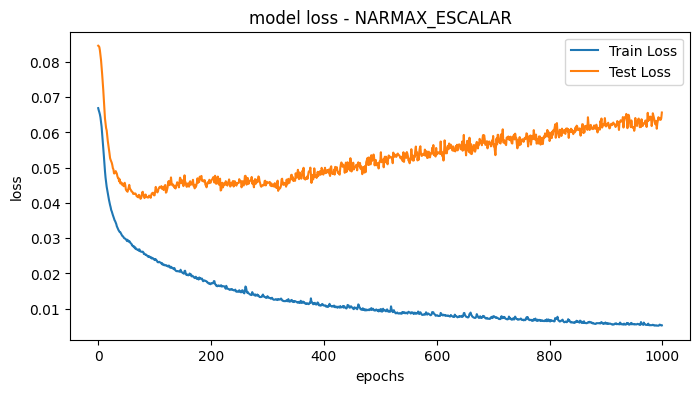

31/31 [==============================] - 0s 2ms/step


,date,real,pred,tipo
0,1932-01-01,1908.0,1862.868246,Treino
1,1932-02-01,1898.0,2030.176164,Treino
2,1932-03-01,1534.0,1631.701239,Treino
3,1932-04-01,868.0,1021.773304,Treino
4,1932-05-01,673.0,660.380417,Treino


,date,real,pred,tipo
967,2012-08-01,340.0,494.398744,Teste
968,2012-09-01,262.0,405.173889,Teste
969,2012-10-01,253.0,341.885946,Teste
970,2012-11-01,435.0,211.399548,Teste
971,2012-12-01,665.0,1030.492457,Teste


,tipo,MSE,MAE,MAPE,R2
0,Treino,81834.230599,187.416584,0.208346,0.782465
1,Teste,129897.414223,236.155630,0.265601,0.652915


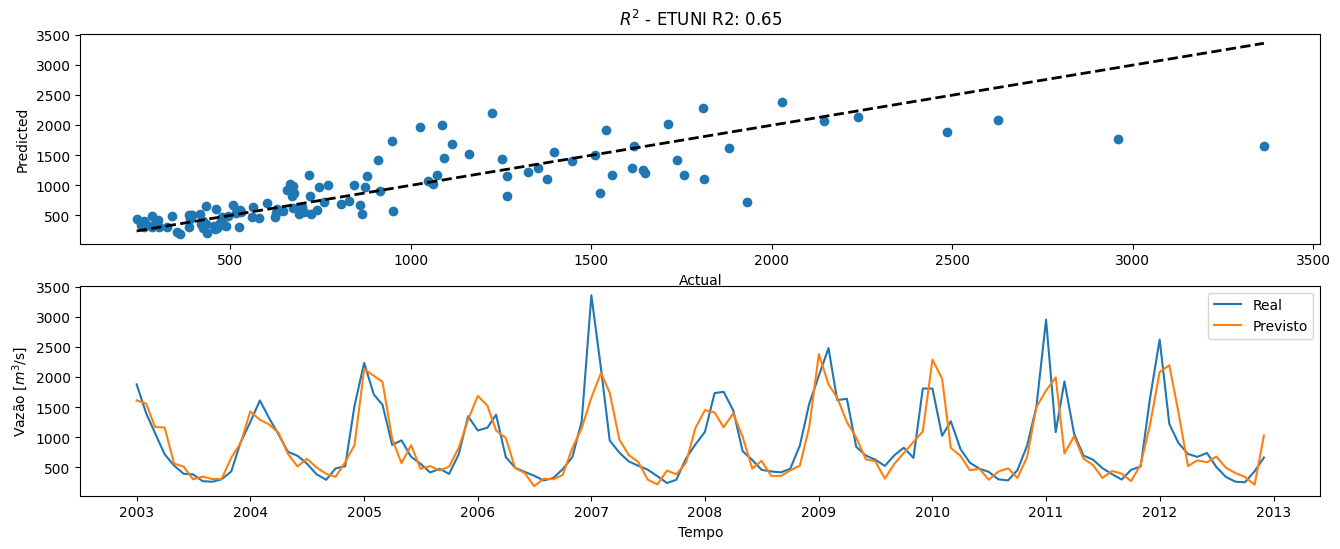

In [13]:
lag_list = [x for x in esc_furnas.columns if 'mean_lag' in x]
pred_list = ['mean_pred_1']
X = esc_furnas[lag_list].copy()
y = esc_furnas[pred_list].copy()

split_esc = esc_furnas.shape[0] - 12*10
split_vec = vec_furnas.shape[0] - 10

X_train, X_test = X.iloc[:split_esc,:],X.iloc[split_esc:,:]
y_train, y_test = y.iloc[:split_esc,:],y.iloc[split_esc:,:]

filePath = "/content/esc_weights_etuni_furnas.hdf5"
model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=filePath,
      save_weights_only=True,
      monitor='val_mse',
      mode='min',
      save_best_only = True
      )



model_esc.fit(X_train, y_train,
              epochs=1000,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_test, y_test),
              callbacks=[model_checkpoint_callback],
              shuffle=True,
              workers=10, use_multiprocessing=True)
  


model_loss(model_esc.history,method_name='NARMAX_ESCALAR')
model_esc.load_weights(filePath)
pred_df = esc_furnas[lag_list].copy()
pred_df[pred_list] = model_esc.predict(esc_furnas[lag_list])
pred_df = etuni_2_abs(pred_df, deltaT=deltaT)[pred_list]


df_escalar = esc_furnas[['date']].copy()
df_escalar['real'] = furnas_scaler.inverse_transform(esc_furnas[['pred_1']])
df_escalar['pred'] = furnas_scaler.inverse_transform(pred_df)
df_escalar['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_escalar.index]
df_escalar.to_csv('furnas_pred_results_etuni.csv',index=False)

display(df_escalar.head())
display(df_escalar.tail())

test = df_escalar[df_escalar.tipo == 'Teste']
train = df_escalar[df_escalar.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('furnas_metrics_esc_etuni.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - ETUNI R2: {r2_result:.2f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'Furnas Escalar results.png', format='png')

plt.show()

In [14]:
aow = esc_bootstrap(esc_furnas,deltaT,furnas_scaler,X,y,lag_list,pred_list,split_esc,sample=100)

44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
teste = pd.concat(aow)
teste.to_csv('teste_furnas_esc_etuni.csv',index=False)

<Axes: xlabel='R2', ylabel='Count'>

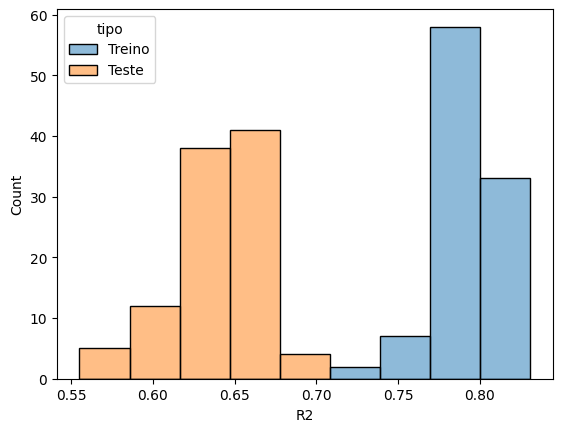

In [18]:
sns.histplot(data=teste, x='R2',hue='tipo')

## Vetorial

In [ ]:
lag_list = [x for x in vec_furnas.columns if 'lag' in x]
pred_list = [x for x in vec_furnas.columns if 'pred' in x]

X = vec_furnas[lag_list].copy()
y = vec_furnas[pred_list].copy()

split_esc = esc_camargos.shape[0] - 12*10
split_vec = vec_camargos.shape[0] - 10

X_train, X_test = X.iloc[:split_vec,:],X.iloc[split_vec:,:]
y_train, y_test = y.iloc[:split_vec,:],y.iloc[split_vec:,:]

# filePath = "/content/furnas_vec_weights_narmax.hdf5"
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#       filepath=filePath,
#       save_weights_only=True,
#       monitor='val_mse',
#       mode='min',
#       save_best_only = True
#       )


model_vec.fit(X_train, y_train,
              epochs=10,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_train, y_train),
              #callbacks=[model_checkpoint_callback],
              shuffle=True)


model_loss(model_vec.history,method_name='NARMAX_VETORIAL')
model_vec.load_weights(filePath)

df_vec = esc_furnas[['date']].copy()
df_vec['real'] = furnas_scaler.inverse_transform(vec_2_esc(y))
df_vec['pred'] = furnas_scaler.inverse_transform(vec_2_esc(pd.DataFrame(model_vec.predict(X))))
df_vec['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_vec.index]
df_vec.to_csv('furnas_pred_results_vec.csv',index=False)


test = df_vec[df_vec.tipo == 'Teste']
train = df_vec[df_vec.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('furnas_metrics_vec.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'Furnas Vetorial results NARMAX.png', format='png')

plt.show()

In [ ]:
lag_list = [x for x in vec_furnas.columns if 'lag' in x]
pred_list = [x for x in vec_furnas.columns if 'pred' in x]

X = vec_furnas[lag_list].copy()
y = vec_furnas[pred_list].copy()

split_esc = esc_furnas.shape[0] - 12*10
split_vec = vec_furnas.shape[0] - 10

X_train, X_test = X.iloc[:split_vec,:],X.iloc[split_vec:,:]
y_train, y_test = y.iloc[:split_vec,:],y.iloc[split_vec:,:]

In [ ]:
aow = vec_bootstrap(esc_furnas,furnas_scaler,X,y,lag_list,pred_list,split_esc,sample=100)

In [ ]:


teste = pd.concat(aow).reset_index(drop=True)
teste

teste.to_csv('teste_camargos_vec_bootstrap.csv',index=False)

sns.histplot(data=teste,x='MAE',hue='tipo',kde=True)